# 研究論文の国際学会採択予測

## コンペティション概要
本コンペでは、論文のタイトル、アブストラクト、キーワードなどの自然言語情報から、その論文が国際学会で採択されるかどうかを予測していただきます。

## 背景・目的
国際学会での論文掲載は、研究者にとっての重要な節目であり、その実績はその後のキャリアに大きな影響を与えます。

論文が採択される可能性は、文章の質、テーマ、研究の新しさなどが影響します。特に、多くの論文が集まる国際学会においては、始めに査読の目に留まる、アブストラクトの品質が特に重要です。

そこで、本コンペでは、論文本文を含まないタイトル・アブストラクト等の情報が、国際学会の採択率にどの程度影響するかを考察したいと思います。

コンペティションを通して、審査者がどのような判断基準で採択を決定しているのかなどの洞察につながれば幸いです。

## Config

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import gensim
import nltk
!python3 --version
print(pd.__version__)
print(np.__version__)
print(sklearn.__version__)
import matplotlib.pyplot as plt
# print(matplotlib.__version__)
print(gensim.__version__)

Python 3.10.11
1.5.3
1.22.4
1.2.2
4.3.1


In [ ]:
from google.colab import drive
import os
import pathlib
import tensorflow as tf

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_dir + 'train_data.csv'

NameError: ignored

In [ ]:
input_dir ="drive/My Drive/Colab Notebooks/competition/202304/" #Drive

train_file = input_dir + 'train_data.csv'
test_file = input_dir + 'test_data.csv'
df = pd.read_csv(train_file, index_col='id')
df_t = pd.read_csv(test_file, index_col='id')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4974 entries, 1 to 4974
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     4974 non-null   object
 1   year      4974 non-null   int64 
 2   abstract  4974 non-null   object
 3   keywords  4494 non-null   object
 4   y         4974 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 233.2+ KB


## EDA

In [ ]:
df['year'].unique()

array([2018, 2019, 2020])

In [ ]:
df.head()

,title,year,abstract,keywords,y
id,,,,,
1,Hierarchical Adversarially Learned Inference,2018,We propose a novel hierarchical generative mod...,"generative, hierarchical, unsupervised, semisu...",0
2,Learning to Compute Word Embeddings On the Fly,2018,Words in natural language follow a Zipfian dis...,"NLU, word embeddings, representation learning",0
3,Graph2Seq: Scalable Learning Dynamics for Graphs,2018,Neural networks are increasingly used as a gen...,NaN,0
4,Generating Differentially Private Datasets Usi...,2018,"In this paper, we present a technique for gene...","generative adversarial networks, differential ...",0
5,Representing dynamically: An active process fo...,2018,We propose an unsupervised method for building...,"Generative Models, Latent representations, Pre...",0


In [ ]:
#データセットの分布
t_nums = df['title'][df['y']==1].count()
f_nums = df['title'][df['y']==0].count()

print(f'True labels:{t_nums}')
print(f'False labels:{f_nums}')
print(f'True Rate:{round(t_nums/f_nums,2)}')

True labels:1523
False labels:3451
True Rate:0.44


In [ ]:
df[df['keywords'].isna()]

,title,year,abstract,keywords,y
id,,,,,
3,Graph2Seq: Scalable Learning Dynamics for Graphs,2018,Neural networks are increasingly used as a gen...,NaN,0
19,SQLNet: Generating Structured Queries From Nat...,2018,Synthesizing SQL queries from natural language...,NaN,0
23,Generative Models for Alignment and Data Effic...,2018,We examine how learning from unaligned data ca...,NaN,0
24,Estimation of cross-lingual news similarities ...,2018,"Every second, innumerable text data, including...",NaN,0
29,BinaryFlex: On-the-Fly Kernel Generation in Bi...,2018,"In this work we present BinaryFlex, a neural n...",NaN,0
...,...,...,...,...,...
4928,BackPACK: Packing more into Backprop,2020,Automatic differentiation frameworks are optim...,NaN,1
4936,Posterior sampling for multi-agent reinforceme...,2020,Posterior sampling for reinforcement learning ...,NaN,1
4940,Cyclical Stochastic Gradient MCMC for Bayesian...,2020,The posteriors over neural network weights are...,NaN,1


In [ ]:
df['keywords'].unique()

array(['generative, hierarchical, unsupervised, semisupervised, latent, ALI, GAN',
       'NLU, word embeddings, representation learning', nan, ...,
       'adversarial examples, adversarial training, provable defense, convex relaxations, deep learning',
       'Question Answering, Multi-Hop QA, Deep Learning, Knowledge Bases, Information Extraction, Data Structures for QA',
       'federated learning'], dtype=object)

## 前処理

In [ ]:
# 大文字を小文字にする
df   = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df_t = df_t.applymap(lambda x: x.lower() if isinstance(x, str) else x)

#単語文字以外を削除
df.replace(to_replace=r'[^\w\s]', value='', regex=True, inplace=True)
df_t.replace(to_replace=r'[^\w\s]', value='', regex=True, inplace=True)

In [ ]:
nltk.download('stopwords')

from nltk.corpus import stopwords
import string

# ストップワードの取得
stop_words = stopwords.words('english')
stop_words.extend(list(string.punctuation))

df['abstract']   = df['abstract'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
df_t['abstract'] = df_t['abstract'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re

# 数字を除去する関数
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# "abstract"カラムの値から数字を除去
df["abstract"]   = df["abstract"].apply(remove_numbers)
df_t["abstract"] = df_t["abstract"].apply(remove_numbers)


In [ ]:
df['abstract']

id
1       propose novel hierarchical generative model si...
2       words natural language follow zipfian distribu...
3       neural networks increasingly used general purp...
4       paper present technique generating artificial ...
5       propose unsupervised method building dynamic r...
                              ...                        
4970    introduce convolutional conditional neural pro...
4971    paper study implicit regularization gradient d...
4972    present colt new method train neural networks ...
4973    consider task answering complex multihop quest...
4974    federated learning allows edge devices collabo...
Name: abstract, Length: 4974, dtype: object

In [ ]:
# NLTKライブラリのダウンロード
nltk.download('punkt')

# DataFrameから文章を取得
abst_sent_tr = df['abstract'].tolist()
abst_sent_ts = df_t['abstract'].tolist()

# 文章の単語数をカウント
sentence_len = []
for sentence in abst_sent_tr:
    tokens = nltk.word_tokenize(sentence)
    sentence_len.append(len(tokens))

print("Total word count:", sentence_len)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Total word count: [96, 73, 88, 58, 116, 87, 111, 93, 129, 80, 91, 160, 108, 125, 34, 157, 162, 53, 113, 73, 110, 90, 104, 78, 70, 97, 137, 153, 62, 88, 167, 120, 121, 125, 80, 108, 144, 92, 94, 101, 104, 95, 78, 94, 95, 84, 60, 91, 120, 73, 99, 120, 79, 119, 62, 89, 108, 123, 94, 92, 87, 47, 101, 77, 98, 79, 124, 80, 148, 119, 116, 124, 128, 108, 127, 112, 133, 103, 85, 70, 93, 78, 85, 116, 118, 100, 96, 79, 96, 84, 111, 109, 68, 129, 89, 58, 100, 50, 89, 40, 137, 86, 57, 111, 94, 62, 82, 113, 97, 106, 83, 122, 100, 98, 71, 99, 129, 105, 154, 88, 74, 102, 138, 91, 89, 96, 76, 93, 104, 50, 73, 98, 109, 113, 139, 100, 84, 89, 97, 66, 111, 84, 146, 65, 179, 43, 91, 130, 126, 91, 87, 124, 166, 93, 124, 133, 130, 97, 123, 94, 90, 89, 81, 115, 96, 80, 54, 84, 79, 70, 39, 68, 111, 123, 117, 96, 88, 80, 117, 114, 105, 47, 92, 153, 96, 98, 96, 96, 129, 65, 95, 70, 75, 75, 84, 69, 69, 122, 106, 116, 82, 102, 94, 64, 78, 79, 80, 70, 105, 64, 54, 120, 95, 83, 80, 85, 104, 97, 86, 91, 81, 84, 104, 

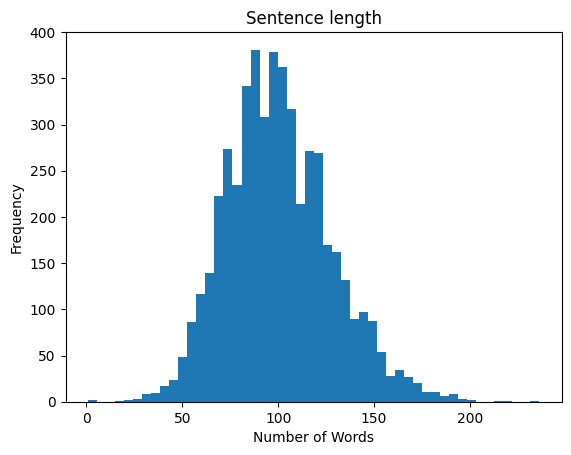

In [ ]:
# ヒストグラムを作成
plt.hist(sentence_len, bins=50)

# グラフのタイトルと軸ラベルを設定
plt.title('Sentence length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# グラフを表示
plt.show()

In [ ]:
mean = np.mean(sentence_len)
median = np.median(sentence_len)
std_dev = np.std(sentence_len)
print("Mean: ", mean)
print("Median: ", median)
print("Standard deviation: ", std_dev)

Mean:  100.45496582227584
Median:  98.0
Standard deviation:  27.397949745375815


In [ ]:
#DFの中で出現頻度が多い単語を調査
from collections import Counter

word_counts = Counter()

for row in df['abstract']:
    words = row.split()
    word_counts.update(words)

In [ ]:
#可視化
view_nums = 10
word_counts.most_common(view_nums)#上位の単語を表示する

[('learning', 6145),
 ('model', 4276),
 ('neural', 3793),
 ('training', 3767),
 ('data', 3716),
 ('networks', 3689),
 ('models', 3331),
 ('network', 3037),
 ('show', 2900),
 ('propose', 2602)]

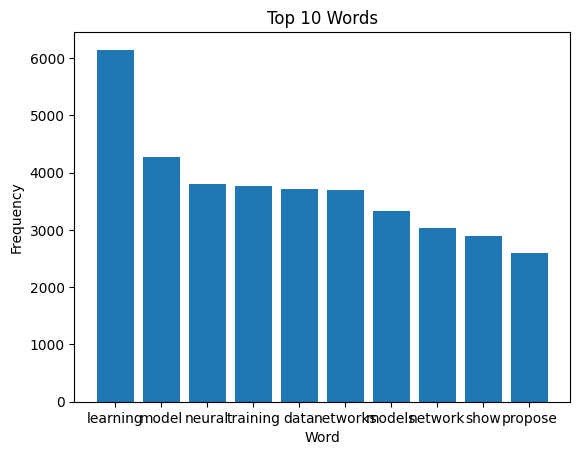

In [ ]:
# 棒グラフで可視化
top_words = dict(word_counts.most_common(view_nums))

plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title(f'Top {view_nums} Words')
plt.show()

## 特徴量作成

In [ ]:
###
##text2Vector by TF-IDF
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
bow_tr = vectorizer.fit_transform(df['abstract'])#4974×１６９４
bow_ts = vectorizer.fit_transform(df_t['abstract'])

from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
tfidf_tr = transformer.fit_transform(bow_tr)
tfidf_ts = transformer.fit_transform(bow_ts)

# print(tfidf.toarray())


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
### BERTによる特徴抽出
import torch
import transformers

from transformers import BertTokenizer


class BertSequenceVectorizer:
    def __init__(self, model_name="bert-base-uncased", max_len=128):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model_name = model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = max_len

    def vectorize(self, sentence: str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()


In [ ]:
BSV = BertSequenceVectorizer(
    model_name="bert-base-multilingual-uncased",
    max_len=128)
abst_features = np.stack(
    df["abstract"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values
)


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NameError: ignored

In [ ]:
###読み込みは下記
import pickle
with open(input_dir+"train_features.pkl", "rb") as f:
    abst_features = pickle.load(f)

with open(input_dir+"test_features.pkl", "rb") as f:
    X_ts = pickle.load(f)

In [ ]:
from scipy.sparse import hstack

abst_features = hstack([abst_features, tfidf_tr])

X_ts= hstack([X_ts, tfidf_ts])

In [ ]:
##

## 学習

# LightGBM
ここはつかってない

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

#inputとTargetの設定

target = df['y'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, target, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

#パラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 63,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

#modelの学習
gbm = lgb.train(params,
                train_data,
                valid_sets=[train_data, valid_data],
                num_boost_round=300,
                early_stopping_rounds=50)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.61375	valid_1's binary_logloss: 0.61542
Training until validation scores don't improve for 50 rounds
[2]	training's binary_logloss: 0.611344	valid_1's binary_logloss: 0.615229
[3]	training's binary_logloss: 0.608974	valid_1's binary_logloss: 0.615078
[4]	training's binary_logloss: 0.60672	valid_1's binary_logloss: 0.614884
[5]	training's binary_logloss: 0.604421	valid_1's binary_logloss: 0.614766
[6]	training's binary_logloss: 0.602084	valid_1's binary_logloss: 0.614719
[7]	training's binary_logloss: 0.599797	valid_1's binary_logloss: 0.61439
[8]	training's binary_logloss: 0.59737	valid_1's binary_logloss: 0.614247
[9]	training's binary_logloss: 0.595102	valid_1's binary_logloss: 0.614094
[10]	training's binary_logloss: 0.592757	valid_1's binary_logloss: 0.61396
[11]	training's binary_loglos

In [ ]:
# X_ts = tfidf_ts.toarray()
# len(X_ts)

X_ts = np.stack(
    df_t["abstract"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values
)


Token indices sequence length is longer than the specified maximum sequence length for this model (726 > 512). Running this sequence through the model will result in indexing errors


In [ ]:

with open(input_dir+"train_features.pkl", "wb") as f:
    pickle.dump(X, f)

with open(input_dir+"test_features.pkl", "wb") as f:
    pickle.dump(X_ts, f)


In [ ]:
### 予測
y_pred = gbm.predict(X_ts,predict_disable_shape_check=True)

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns=['abstract','y'])

# IDを追加
y_pred_df['id'] = df_t.index.values

# IDを先頭カラムに移動
y_pred_df = y_pred_df[['id', 'y']]

In [ ]:
plt.hist(y_pred_df['y'],bins=50);

In [ ]:
threshold = 0.35
y_pred_df['y'] = np.where(y_pred_df['y'] >= threshold, 1, 0)
y_pred_df['y'].sum()

# BERT
ここをつかいました

In [ ]:
df_b =df[['abstract','y']]
df_b.columns = ['text','label']#ラベル名は決まっているので固定化
df_b["label"] = df_b["label"].astype("int")#ラベルをintegerにしておく

from sklearn.model_selection import train_test_split

train_df,eval_df=train_test_split(df_b,test_size=0.1,shuffle=0.3,random_state=0)
train_df, eval_df

<ipython-input-15-255210d1e286>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b["label"] = df_b["label"].astype("int")#ラベルをintegerにしておく


(                                                   text  label
 id                                                            
 2876  introduce trimap dimensionality reduction tech...      0
 1560  study problem bellman residual minimization no...      0
 4392  adversarial examples raise questions whether n...      1
 4291  deep neural networks dnns shown overfit datase...      1
 1832  generative neural networks map standard possib...      0
 ...                                                 ...    ...
 4932  typical sequence prediction problems language ...      1
 3265  work present waveflow smallfootprint generativ...      0
 1654  deep neural networks achieved outstanding perf...      0
 2608  paper study adversarial attack defence problem...      0
 2733  consensus yet question whether adaptive gradie...      0
 
 [4476 rows x 2 columns],
                                                    text  label
 id                                                            
 2138  recur

In [ ]:
!pip install simpletransformers
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import accuracy_score

In [ ]:
#学習用パラメータ
params = {
    "max_seq_length": 128,#シークエンスの最大長。この値が大きいと文章の表現力が高くなってより高い精度が期待できる。大きすぎるとoverfittingや学習時間の増大などが生じる可能性がある。
    "train_batch_size": 64,#訓練時のバッチサイズ
    "eval_batch_size": 32,
    "num_train_epochs": 10,
    "use_early_stopping": True,
    "learning_rate": 1e-5,
    "n_gpu": 4,
    "overwrite_output_dir":True
}
weight = 1/ pd.DataFrame((train_df.label).tolist()).reset_index().groupby(0).count().values#不均衡データに対処するためのパラメーター
weight_sum = weight.sum()
weight /= weight_sum

#モデルのトレーニング
model = ClassificationModel('roberta', 'roberta-base', args=params, num_labels=2, use_cuda=True)
model.train_model(train_df)

result, model_outputs, wrong_predictions = model.eval_model(eval_df)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4476 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/70 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/70 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/70 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/70 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/70 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/70 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/70 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/70 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/70 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/498 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

0.7028112449799196


In [ ]:
#Prediction
y_pred, raw_outputs = model.predict(df_t["abstract"].tolist())


  0%|          | 0/6393 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns=['y'])

# IDを追加
y_pred_df['id'] = df_t.index.values

# IDを先頭カラムに移動
y_pred_df = y_pred_df[['id', 'y']]

In [ ]:
y_pred_df

,id,y
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
6388,6389,0
6389,6390,0
6390,6391,0
6391,6392,0


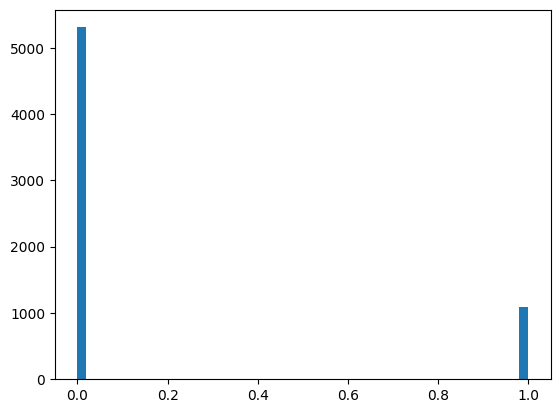

In [ ]:
plt.hist(y_pred_df['y'],bins=50);

## 保存

In [ ]:
import datetime
now = datetime.datetime.now()
now_str = now.strftime('%Y%m%d_%H%M%S')  # 日時を文字列に変換

y_pred_df.to_csv(input_dir+f'result_{now_str}.csv', index=False)  # ファイル名に日時を付与して出力